# Three Objective Multi-stakeholder Example
Created by Alex Dowling at the University of Wisconsin-Madison

## Step 0: Setup

### Load Modules

In [8]:
using JuMP
using PyPlot
using Gurobi

### Define Problem

In [9]:
type ProbData
	xUpperBound
	A
	b
	
	ProbData() = new(2/3,[1 1 1],1)
end

type Solution

	f # Array of objective function values
	z # Either a single float or an array of floats
	alpha # Either a float or empty	
	cvar # Either a float or empty

	x

end

function generateBaseModel(d)
# Create instance of base module using ProbData object "d"

	m = Model()

	@defVar(m, 0 <= x[1:3] <= d.xUpperBound)
	@defVar(m, f[1:3])
	@addConstraint(m, SINGLE_CONSTRAINT, d.A[1]*x[1] + d.A[2]*x[2] + d.A[3]*x[3] >= d.b)
	@addConstraint(m, OBJECTIVES[i=1:3], x[i] == f[i])
	
	return m
	
 end

function assembleSolution(m,alpha)

	f = getVar(m, :f)
	z = getVar(m, :z)

	x = getVar(m, :x)
		
	if(0 <= alpha && alpha <= 1)
		cvar = getVar(m, :cvar)
		s = Solution(getValue(f),getValue(z),alpha,getValue(cvar),getValue(x))
	else
		s = Solution(getValue(f),getValue(z),[],[],getValue(x))
	end

end

assembleSolution (generic function with 1 method)

### Load CVaR Library

In [10]:
include("generic_CVaR_library.jl")

computeNadirUtopiaPoints (generic function with 1 method)

## Step 1: Calculate nadir and utopia points

In [11]:
# Determine Utopia and Nadir points
d = ProbData()

# Input 2: Number of objectives
# Input 3: Use alternate nadir point (true/false)
mooData = computeNadirUtopiaPoints(d, false)

MOOProbData(3,3x3 Array{Float64,2}:
 0.0       0.666667  0.666667
 0.666667  0.0       0.666667
 0.666667  0.666667  0.0     ,3x3 Array{Float64,2}:
 0.0       0.333333  0.666667
 0.333333  0.0       0.666667
 0.333333  0.666667  0.0     ,[0.0,0.0,0.0],[0.6666666666666666,0.6666666666666666,0.6666666666666666],[0.33333333333333337,0.6666666666666666,0.6666666666666666],false)

## Step 2 & 3: Determine ideal solutions & solve CVaR formulation

### Define helper function

In [12]:
function solveWithRandW(d,mooData,nStake)

	nObj = mooData.nObj
	nX = 3
	
	### Generate Stakeholders
	W = rand(nStake,nObj)

	for i = 1:size(W,1)
		W[i,:] = W[i,:] / sum(W[i,:])
	end

	stakeholderData = solveForPreferredPoints(d,W,mooData)

	# Iterate over alpha values and save results
	alpha = 0:0.01:1
	X = zeros(length(alpha),nX)
	Z = X

	nS = length(alpha)
	slnVector = Array(Solution,nS)

	for i = 1:nS
		slnVector[i] = solveCVaRProblem(d,stakeholderData,alpha[i])
		for j = 1:nX
			X[i,j] = slnVector[i].x[j]
		end
	end

	return (alpha, X, W, slnVector, stakeholderData)
end

solveWithRandW (generic function with 1 method)

### Evaluate for 4 randomly generated stakeholder sets

In [13]:
# Seed random number generator
srand(2015)

# Specify number of stakeholders
nStakeholders = 500

(alpha1, X1, W1, sv1, sd1) = solveWithRandW(d,mooData, nStakeholders)
(alpha2, X2, W2, sv2, sd2) = solveWithRandW(d,mooData, nStakeholders)
(alpha3, X3, W3, sv3, sd3) = solveWithRandW(d,mooData, nStakeholders)
(alpha4, X4, W4, sv4, sd4) = solveWithRandW(d,mooData, nStakeholders)

LoadError: LoadError: InterruptException:
while loading In[13], in expression starting on line 8

## Plot Results

### Plot Pareto surface

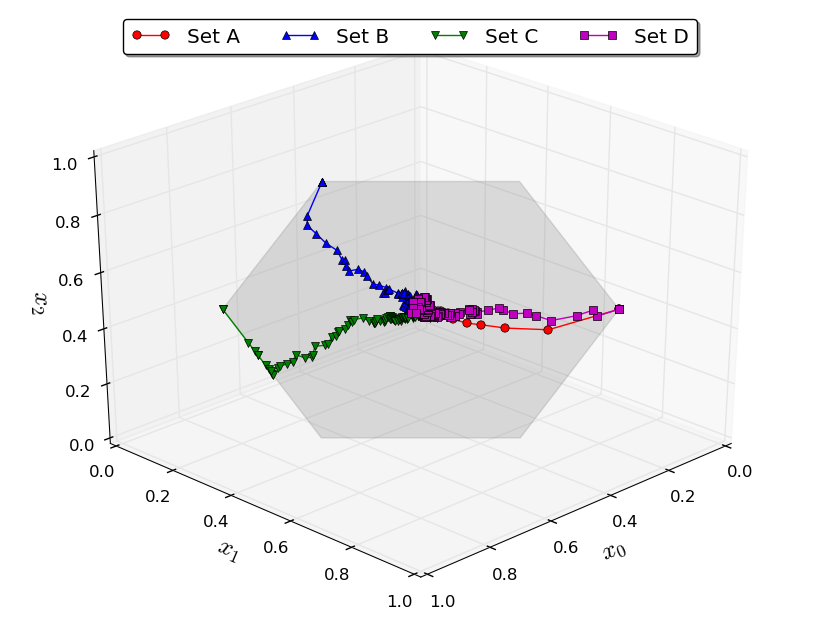

In [14]:
### Plot Pareto surface

# Define vertices
x = [2/3; 2/3; 1/3; 0;   0;   1/3]
y = [1/3; 0;   0;   1/3; 2/3; 2/3]
z = [0;   1/3; 2/3; 2/3; 1/3; 0]

# Create polygon
Poly3DCollection = PyPlot.mplot3d[:art3d][:Poly3DCollection]
fig = figure()
ax = Axes3D(fig)
verts = (collect(zip(x,y,z)),)
ax[:add_collection3d](Poly3DCollection(verts, color = "gray", alpha=0.25)) 

### Plot CVaR results for each stakeholder sample
plot3D(X1[:,1], X1[:,2], X1[:,3],color="r", marker="o",label="Set A")
plot3D(X2[:,1], X2[:,2], X2[:,3],color="b", marker="^",label="Set B")
plot3D(X3[:,1], X3[:,2], X3[:,3],color="g", marker="v",label="Set C")
plot3D(X4[:,1], X4[:,2], X4[:,3],color="m", marker="s",label="Set D")

### Adjust plot aesthetics
xlabel(L"x_0",fontsize=18)
ylabel(L"x_1",fontsize=18)
zlabel(L"x_2",fontsize=18)

xlim(0,1)
ylim(0,1)
zlim(0,1)

legend(bbox_to_anchor=(0.5, 1.0), loc="upper center", ncol=4, fancybox="True", shadow="True")

ax[:view_init](30,45)